## 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [1]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
# загрузим датасет
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


Посмотрим на данные

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [5]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

Переименуем признаки conversion и offer

In [6]:
df.rename(columns={'offer': 'treatment', 'conversion': 'target'},inplace=True)

сделаем признак treatment бинарным

In [7]:
df['treatment'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: treatment, dtype: int64

In [8]:
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0

df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

выделим категориальные признаки

In [9]:
cat_features = ['zip_code', 'channel']
df.head(4)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0


3 сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

Первый доп признак - это отношение исторической суммы покупок к количеству месяцев с последней активности. Чем больше месяцев клиент не пользовался нашим сервисом, тем сильнее будет дисконтироваться сумма его исторических трат

In [10]:
df['history_per_recency'] = df['history'] / df['recency']

Второй признак - это маркетинговая аткивность клиента. Среди признаков есть used_bogo (ранее пользовался акцией "Покупай один товар, второй в подарок" и used_discount (ранее п=откликался на предложение о скидке). Новый признак позволит выделить маркетингово активных клиентов, которые пользовались всеми маркетинговыми предожениями (и bogo, и discount)

In [11]:
df['marketing_active'] = df['used_discount'] + df['used_bogo'] 

4. сделать разбиение набора данных не тренировочную и тестовую выборки

In [12]:
from sklearn.model_selection import cross_val_score, train_test_split

#разбиваем признаковое описание клиентов и целевое действие
X_train, X_test, y_train, y_test = train_test_split(df.drop(['treatment','target'], 1), 
                                                    df['target'], random_state=0)
#разбиваем флаг наличия коммуникации                                                  
treat_train = df.loc[X_train.index,'treatment']
treat_test = df.loc[X_test.index,'treatment']

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [13]:
!pip install scikit-uplift catboost==0.22 -U
!pip install causalml

     |████████████████████████████████| 64.4MB 43kB/s 
     |████████████████████████████████| 245kB 24.2MB/s 
     |████████████████████████████████| 20.1MB 39.8MB/s 
     |████████████████████████████████| 327kB 35.2MB/s 
     |████████████████████████████████| 1.8MB 35.6MB/s 
     |████████████████████████████████| 634kB 39.4MB/s 
  Created wheel for causalml: filename=causalml-0.10.0-cp37-cp37m-linux_x86_64.whl size=493686 sha256=c1622fdddbf6a646cd3a5cc85fc3f9878ee5674d22020003372d3b2860a25c24
  Stored in directory: /root/.cache/pip/wheels/81/7f/44/c9d5ecf03f0d950f53302a5eab1c76bec07bcd5868753e22bf
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465029 sha256=2137d7c2ed36ef75de3f65085d275f81868060bf1a22c377f13afef51a9eafd2
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which i

In [14]:
# словарь для записывания результатов
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

**Модель SoloModel**

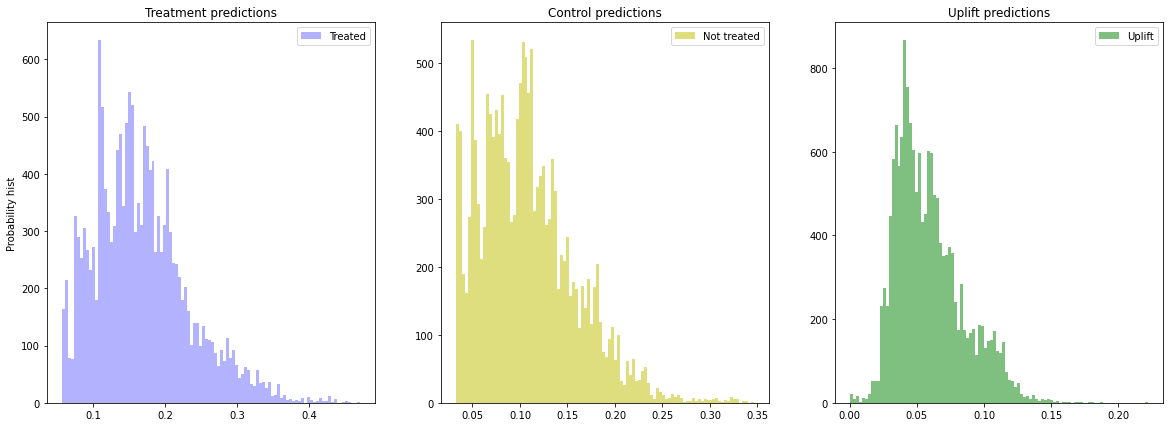

In [15]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds ## в новой версии проблема (беру свой вариант)
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

sm = SoloModel(  CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(  X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k( y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k( y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k( y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(sm_trmnt_preds , sm_ctrl_preds, bins=100);

**Построим модель с трансформацией классов**

In [16]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


**Построим две независимые модели**

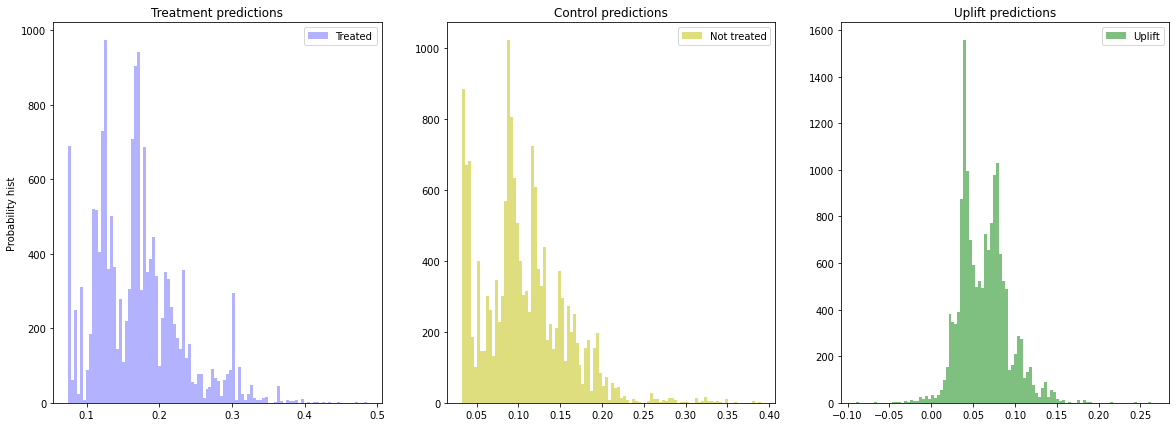

In [17]:
from sklift.models import TwoModels


tm = TwoModels(  
    estimator_trmnt=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=10, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [18]:
table = pd.DataFrame(data=models_results)
table['avg'] = (table['uplift@10%'] + table['uplift@20%'] +table['uplift@30%']) / 3

table

,approach,uplift@10%,uplift@20%,uplift@30%,avg
0,SoloModel,0.059211,0.074378,0.062913,0.065500
1,ClassTransformation,0.062893,0.069766,0.051980,0.061546
2,TwoModels,0.064092,0.070891,0.063932,0.066305


7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [19]:
X_train_tree = pd.concat([X_train.drop(cat_features, 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code'),
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)
X_test_tree = pd.concat([X_test.drop(cat_features, 1), 
                          pd.get_dummies(X_test['zip_code'], prefix='zip_code'),
                         pd.get_dummies(X_test['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


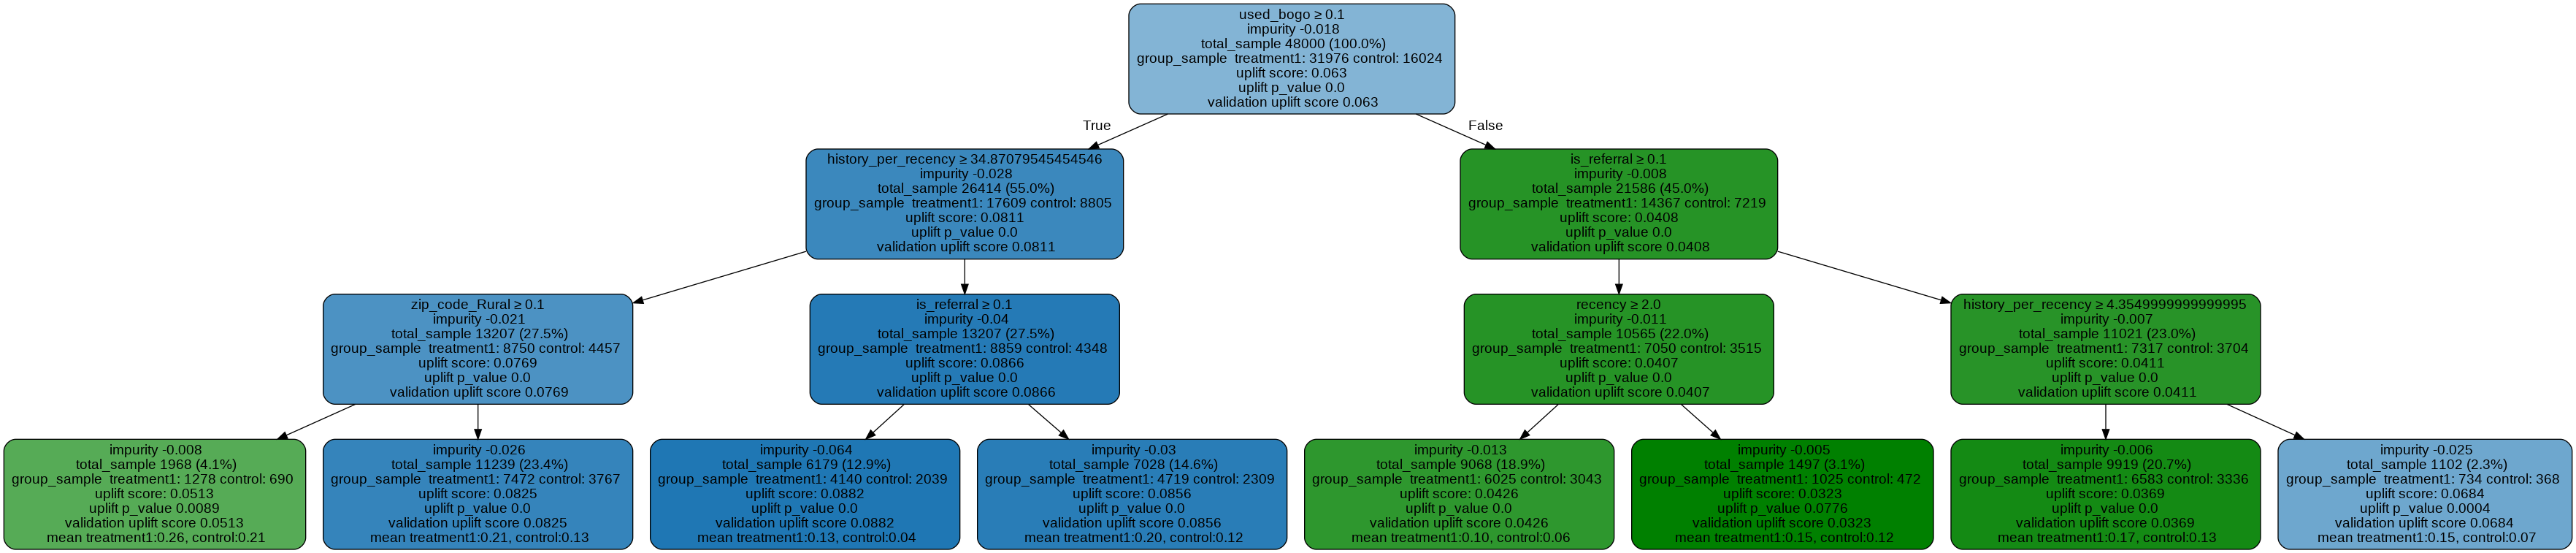

CPU times: user 3.69 s, sys: 352 ms, total: 4.04 s
Wall time: 7.06 s


In [20]:
%%time
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

В каждой ноде мы можем посмотреть признак и порог, по которому производится разбиение. Также  можно посмотреть количество объектов из treatment и control выборок, уровень uplift score в данной ноде, а также оценить уровень статистической значимости (p_value). В итоге по каждому конечному листу можно понять историю разбиения его по признакам и порогам, понять уровень uplift для этого листа и его статистическую значимость. Я обратил внимание,что наиболее надежные результаты имеют темно-синий цвет, ненадежные - зеленый.

Опишу разбиение на примере второго терминального листа слева.Это объекты,которые имеют: 1) значения used_bogo = 1 (порог >=0,1), 2) имеют значение признака  history_per_recency > 34,87 (это отношение исторической суммы покупок к количеству месяцев с последней активности); 3) живут в городе.В данный лист попало 11239 наблюдений,из них treatment = 7472, control=3767. Uplift score = 0.0825 (средний uplift для treatment=0.21, для control=0.13) при p-value=0, что говорит о высокой статистической надежности такого уровня аплифта для этих наблюдений.

На опциональные задания, к сожалению, нет времени